In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import transformers
from transformers import LayoutLMv2Processor, LayoutLMForTokenClassification, AdamW, AutoTokenizer
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import logging
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix
import seaborn as sns

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

from src.metrics import confusion_matrix
from src.preprocessing.make_dataset import ImageLayoutDataset
from src.model.trainer import LayoutLMTrainer

In [3]:
!mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [4]:
model_name = "layoutlm"
dataset_name = "cord"

In [5]:
logging.basicConfig(filename='logs/layoutlm_cord.log', encoding='utf-8', level= logging.INFO)

## Obtaining data

In [6]:
dataset = load_dataset("katanaml/cord")

Repo card metadata block was not found. Setting CardData to empty.


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 800
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 100
    })
})

In [8]:
dataset['train'].features['ner_tags'].feature.names

['O',
 'I-menu.cnt',
 'I-menu.discountprice',
 'I-menu.nm',
 'I-menu.num',
 'I-menu.price',
 'I-menu.sub_cnt',
 'I-menu.sub_nm',
 'I-menu.sub_price',
 'I-menu.unitprice',
 'I-sub_total.discount_price',
 'I-sub_total.etc',
 'I-sub_total.service_price',
 'I-sub_total.subtotal_price',
 'I-sub_total.tax_price',
 'I-total.cashprice',
 'I-total.changeprice',
 'I-total.creditcardprice',
 'I-total.emoneyprice',
 'I-total.menuqty_cnt',
 'I-total.menutype_cnt',
 'I-total.total_etc',
 'I-total.total_price']

In [9]:
n_classes = len(dataset['train'].features['ner_tags'].feature.names)
n_classes

23

In [10]:
llm_tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutlm-base-uncased",)

In [11]:
train_dataset = ImageLayoutDataset(dataset['train'], llm_tokenizer)

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [00:01<00:00, 515.37it/s]


In [12]:
validation_dataset = ImageLayoutDataset(dataset['validation'], llm_tokenizer)

 54%|█████▍    | 54/100 [00:00<00:00, 535.66it/s]

100%|██████████| 100/100 [00:00<00:00, 543.62it/s]


In [13]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle = False
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle = False
)

## Importing model

In [14]:
device = "cuda"

In [15]:
layoutlm = LayoutLMForTokenClassification.from_pretrained('microsoft/layoutlm-base-uncased', num_labels = n_classes)
layoutlm.to(device)

Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0-11): 12 x LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
 

In [16]:
print(f'''
    Model Info
    -----------------
    
    Treinable params: {sum(p.numel() for p in layoutlm.parameters() if p.requires_grad)}
    Non Treinable params: {sum(p.numel() for p in layoutlm.parameters() if not p.requires_grad)}

''')


    Model Info
    -----------------
    
    Treinable params: 112645655
    Non Treinable params: 0




In [17]:
trainer = LayoutLMTrainer(
    layoutlm,
)

In [18]:
trainer.compile(
    train_dataloader,
    validation_dataloader,
    n_classes= n_classes,
    device = "cuda"
)

/users/eleves-a/2022/pedro.silva/few-shot-learning-transformers/.venv/lib64/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [04:16<00:00, 25.68s/it]


In [19]:
best_idx = None
for idx, f1 in enumerate(trainer.history['validation-f1']):
    if f1 == trainer.best_f1:
        best_idx = idx 

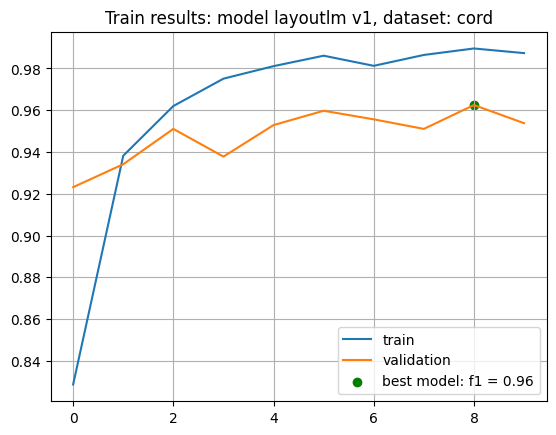

In [20]:
plt.plot(trainer.history['train-f1'],
         label = "train")
plt.plot(trainer.history['validation-f1'],
         label = "validation")

plt.title(f"Train results: model {trainer.model_name}, dataset: {dataset_name}")
plt.scatter(
    best_idx,
    trainer.best_f1.item(), 
    color = "green",
    label = f"best model: f1 = {round(trainer.best_f1.item(), 2)}"
)
plt.grid()
plt.legend()

In [21]:
trainer.history['validation-f1']

[0.9231473207473755,
 0.9341262578964233,
 0.9510521292686462,
 0.9377859234809875,
 0.9528819918632507,
 0.959743857383728,
 0.9556267261505127,
 0.9510521292686462,
 0.96248859167099,
 0.9537968635559082]

In [22]:
trainer.history['train-f1']

[0.828652560710907,
 0.9382033944129944,
 0.9620031118392944,
 0.9751161336898804,
 0.9811047911643982,
 0.9861125349998474,
 0.9812597036361694,
 0.9864739179611206,
 0.9895715117454529,
 0.9873515963554382]

## Performance analysis

In [29]:
feature_names = dataset['train'].features['ner_tags'].feature.names
keymap = {i : v for i, v in enumerate(feature_names)}

In [30]:
y_pred, y_true = trainer.evaluate(validation_dataloader)

In [31]:
errors = y_pred[y_pred != y_true ]

In [32]:
conf_matrix = confusion_matrix(
    y_pred,
    y_true,
    n_classes,
    keymap
)

Text(0.5, 1.0, 'Confusion matrix- model: layoutlm, dataset : cord')

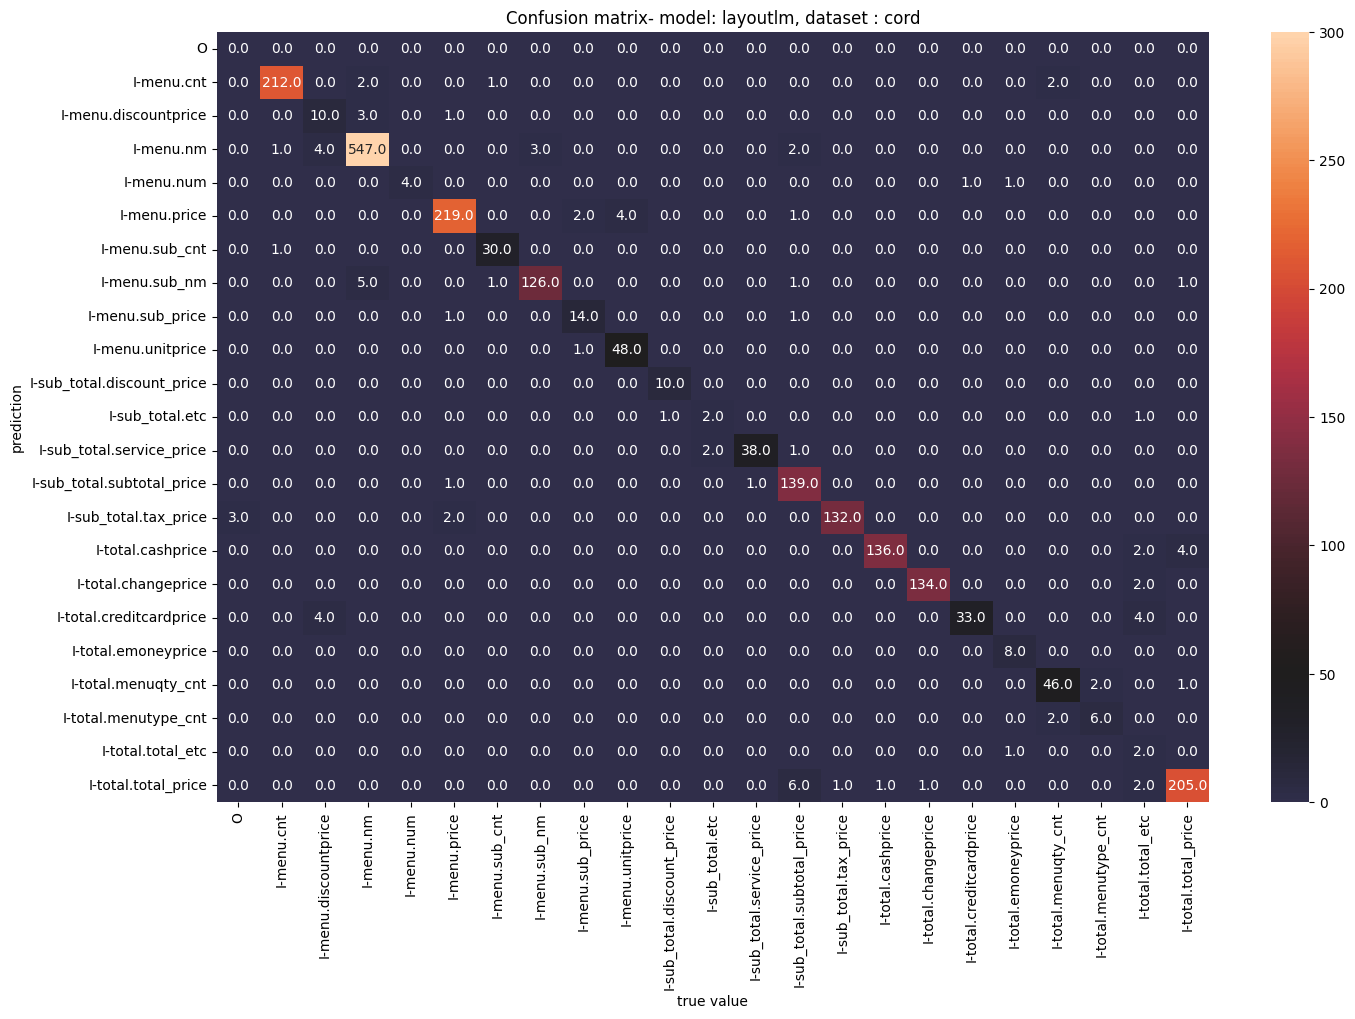

In [33]:

plt.figure(figsize=(16,10))
sns.heatmap(conf_matrix,
            annot=True,
            vmax=300,
            center= 50,
            fmt = '.1f')

plt.title(f"Confusion matrix- model: {model_name}, dataset : {dataset_name}")

### Verifying image

In [39]:
def unnormalize_bbox(bbox, width, height):
    return [
        int( (bbox[0] * width /1000)),
        int((bbox[1] * height /1000)),
        int((bbox[2] * width /1000)),
        int((bbox[3] * height / 1000)),
    ]

In [40]:
font = ImageFont.load_default()

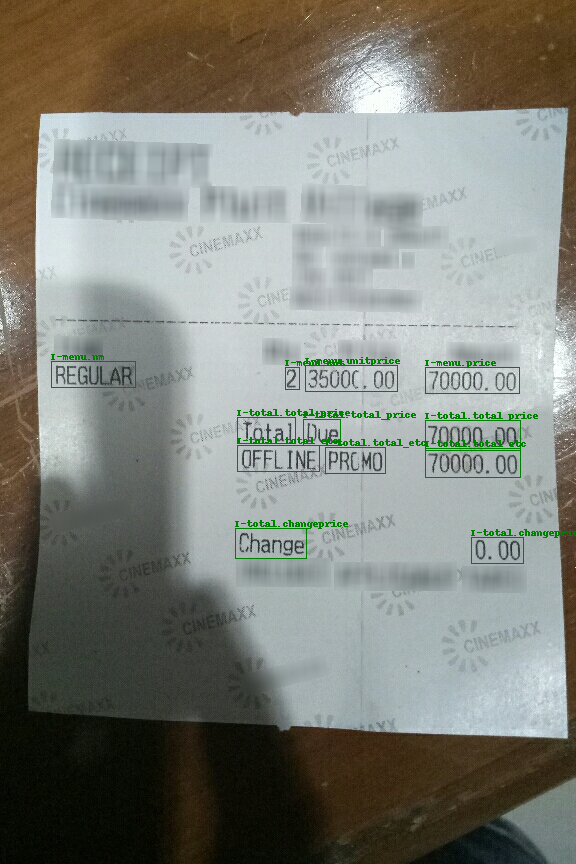

In [56]:
img_idx = 90
example = train_dataset.encode(dataset['validation'][img_idx])

y_pred, y_true = trainer.evaluate(
    example
)

target = example['labels'].to("cuda")
mask = [target!= -100]
target = target

boxes = example['bbox'].to("cuda")

img = Image.open(dataset['validation'][img_idx]['image_path'],)
rgbimg = Image.new("RGB", img.size)
rgbimg.paste(img)

img = rgbimg

unnormalized_box = [
    unnormalize_bbox(b, img.width, img.height) for b in dataset['validation'][img_idx]['bboxes']
]


real_boxes = torch.tensor(
    unnormalized_box,
    device="cuda",
)
new_img = img.copy()

for idx, box in enumerate(real_boxes):
    # if y_true[idx] == y_pred[idx]:
    #     continue

    draw = ImageDraw.Draw(img,)
    coordinates =  list(box.to("cpu").numpy())
    draw.rectangle(
        coordinates,
        outline= "green"
    )
    draw.text(
        [coordinates[0], coordinates[1] - 10], 
        keymap[y_true[idx].item()], 
        font= font,
        fill = "green"
    )

    draw2 = ImageDraw.Draw(new_img,)
    coordinates =  list(box.to("cpu").numpy())
    draw2.rectangle(
        coordinates,
        outline = "red"
    )
    draw2.text(
        [coordinates[0], coordinates[1] - 10], 
        keymap[y_pred[idx].item()], 
        font= font,
        fill = "red"
    )


img.resize(np.array(img.size)//1)